In [1]:
import pandas as pd
import numpy as np
import random

print("Generating mock dataset...")

# 1. Your list of 95 police stations
police_stations = [
    "Vanrai", "Bangur Nagar", "Meghwadi", "Bandra", "Vakola", "Ghatkopar",
    "Chembur", "Dadar", "Bhoiwada", "Tardeo", "Yellow Gate", "Pydhonie",
    "Colaba", "Dindoshi", "Goregaon", "Sakinaka", "Khar", "VileParle",
    "PantNagar", "Nehru Nagar", "Shivaji Park", "Kalachowki", "Nagpada",
    "Wadala", "L. T. Marg", "Cuffe Parade", "Kurar", "Malad", "Powai",
    "Santacruz", "Kherwadi", "Vikhroli", "Trombay", "Mahim", "Matunga",
    "Agripada", "Sewree", "V. P. Road", "Azad Maidan", "Samta Nagar",
    "Malvani", "M I D C", "Juhu", "B.K.C.", "Kanjurmarg", "R.C.F.",
    "Shahu nagar", "R.A.K. Marg", "Byculla", "Dr.D.B Marg", "M.R.A. Marg",
    "Kasturba marg", "Borivali", "Andheri", "D. N. Nagar", "Nirmal Nagar",
    "Navghar", "Deonar", "Kurla", "Sion", "Worli", "Gamdevi", "Dongri",
    "Dahisar", "Kandivali", "Jogeshwari", "Versova", "Sahar", "Bhandup",
    "Shivaji Nagar", "Vinoba Bhave Nagar", "Antop Hill", "N. M. Joshi Marg",
    "Malabar Hill", "Sir J.J. Marg", "Aarey", "Charkop", "Oshiwara",
    "Airport", "Mulund", "Tilak Nagar", "Dharavi", "Wadala Truck Terminal",
    "Marine Drive", "M.H.B. Colony", "Amboli", "Parksite", "Chunabhatti",
    "Gorai", "Mankhurd", "Govandi"
]

# 2. Your date range: Jan 2022 to Sep 2025
# 'ME' means "Month End"
dates = pd.date_range(start='2022-01-31', end='2025-09-30', freq='ME')

# 3. Create a base crime rate for each station to make data realistic
# (Some stations will just naturally have more crime than others)
station_base_rates = {}
for station in police_stations:
    # Assign a random base crime level between 40 and 350
    station_base_rates[station] = random.randint(40, 350)

# 4. Build the dataset
data = []
for date in dates:
    for station in police_stations:
        # Get the station's base crime
        base_crime = station_base_rates[station]
        
        # Add some random monthly variation (e.g., +/- 30)
        # Also add a slight seasonal upward trend in summer (May/June)
        seasonal_effect = 0
        if date.month in [5, 6]:
            seasonal_effect = random.randint(10, 50) # Summer spike
        
        monthly_variation = random.randint(-30, 30) + seasonal_effect
        
        # Calculate final crime, ensure it's not negative
        total_crimes = base_crime + monthly_variation
        if total_crimes < 0:
            total_crimes = base_crime / 2 # Just use a lower number
        
        data.append([date.strftime('%Y-%m-%d'), station, int(total_crimes)])

# 5. Create the DataFrame
df = pd.DataFrame(data, columns=['Date', 'Police_Station', 'Total_Crimes'])

# 6. Save to CSV file
df.to_csv('mock_crime_history.csv', index=False)

print(f"Successfully created 'mock_crime_history.csv' with {len(df)} rows.")

Generating mock dataset...
Successfully created 'mock_crime_history.csv' with 4095 rows.


In [1]:
from shapely.ops import unary_union, voronoi_polygons

ImportError: cannot import name 'voronoi_polygons' from 'shapely.ops' (c:\Users\nitaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py)

In [2]:
from shapely import unary_union, voronoi_polygons      # <-- IMPORT FOR SHAPELY 2.0+

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.ops import unary_union
from shapely import voronoi_polygons
import numpy as np
from sklearn.linear_model import LinearRegression
from flask import Flask, jsonify, request
from flask_cors import CORS
from fuzzywuzzy import process, fuzz
import datetime

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.ops import unary_union
from shapely import voronoi_polygons
import numpy as np
from sklearn.linear_model import LinearRegression
from flask import Flask, jsonify, request
from flask_cors import CORS
from fuzzywuzzy import process, fuzz
import datetime
print("✅ This is the UPDATED version of app.py running now!")

# --- Configuration ---
COORDS_FILE = r'C:\Users\nitaa\Downloads\foml_crime_predictor\Police_Station_Coords.csv'
HISTORY_FILE = r'C:\Users\nitaa\Downloads\foml_crime_predictor\mock_crime_history.csv'
MUMBAI_BBOX = (72.77, 18.89, 73.0, 19.28)  # (min_lon, min_lat, max_lon, max_lat)

# --- Globals ---
app = Flask(__name__)
CORS(app)
station_models = {}
gdf_zones = None
crime_history = None
BASE_START_DATE = datetime.date(2022, 1, 1)

# --- Helper ---
def clean_station_name(name):
    if not isinstance(name, str):
        return ""
    return (
        name.lower()
        .replace(" police station", "")
        .replace(" (w)", "")
        .replace(" (e)", "")
        .replace(" road", "")
        .replace(" marg", "")
        .replace("t.t.", "truck terminal")
        .replace(".", "")
        .replace(" ", "")
    )

# --- FIXED FUNCTION ---
def create_voronoi_zones(gdf_stations):
    """Creates GeoDataFrame of Voronoi zones (jurisdictions) from station points."""
    print("Creating Voronoi zones...")

    # 1. Create bounding box
    min_lon, min_lat, max_lon, max_lat = MUMBAI_BBOX
    bbox_polygon = Polygon([
        (min_lon, min_lat), (max_lon, min_lat),
        (max_lon, max_lat), (min_lon, max_lat)
    ])

    try:
        # ✅ Properly create MultiPoint geometry
        points = MultiPoint(list(gdf_stations.geometry))
        polygons_collection = voronoi_polygons(points, extend_to=bbox_polygon)
    except Exception as e:
        print(f"Error generating Voronoi polygons: {e}")
        return None

    # Convert to GeoDataFrame
    gdf_voronoi = gpd.GeoDataFrame(
        geometry=list(polygons_collection.geoms), crs="EPSG:4326"
    )

    # Attach station names by index
    gdf_stations = gdf_stations.reset_index(drop=True)
    gdf_voronoi = gdf_voronoi.reset_index(drop=True)

    if len(gdf_voronoi) != len(gdf_stations):
        print(f"⚠️ Warning: Voronoi polygons ({len(gdf_voronoi)}) ≠ stations ({len(gdf_stations)})")
        min_len = min(len(gdf_voronoi), len(gdf_stations))
        gdf_voronoi = gdf_voronoi.iloc[:min_len]
        gdf_stations = gdf_stations.iloc[:min_len]

    gdf_voronoi['Police_Station_Coords'] = gdf_stations['Police_Station_Coords']

    # Clip polygons to Mumbai boundary
    gdf_voronoi['geometry'] = gdf_voronoi.geometry.intersection(bbox_polygon)

    print(f"Voronoi zones created successfully. Found {len(gdf_voronoi)} zones.")
    return gdf_voronoi

# --- ML TRAINING ---
def train_all_models(df_history, all_stations):
    print(f"Training {len(all_stations)} ML models...")
    models = {}

    historical_stations = df_history['Police_Station_History'].unique()

    for station_coords_name in all_stations:
        clean_coords_name = clean_station_name(station_coords_name)
        best_match, score = process.extractOne(
            clean_coords_name, historical_stations, scorer=fuzz.token_sort_ratio
        )

        if score > 80:
            station_df = df_history[df_history['Police_Station_History'] == best_match].copy()
            station_df['Date'] = pd.to_datetime(station_df['Date'])
            station_df = station_df.sort_values(by='Date')

            if len(station_df) > 1:
                station_df['time_index'] = (
                    (station_df['Date'].dt.year - BASE_START_DATE.year) * 12 +
                    (station_df['Date'].dt.month - BASE_START_DATE.month)
                )

                X = station_df[['time_index']]
                y = station_df['Total_Crimes']

                model = LinearRegression()
                model.fit(X, y)

                models[station_coords_name] = {
                    'model': model,
                    'history_name': best_match
                }

    print(f"Training complete. {len(models)} models trained.")
    return models

# --- PREDICTION ---
def predict_crime(station_name, target_date_str):
    global crime_history, station_models, BASE_START_DATE
    target_date = datetime.datetime.strptime(target_date_str, '%Y-%m-%d').date()

    if station_name not in station_models:
        return 0, 'N/A'

    model_data = station_models[station_name]
    history_name = model_data['history_name']

    historical_record = crime_history[
        (crime_history['Police_Station_History'] == history_name) &
        (crime_history['Date_str'] == target_date_str)
    ]

    if not historical_record.empty:
        return int(historical_record['Total_Crimes'].values[0]), 'Historical'

    model = model_data['model']
    time_index = (
        (target_date.year - BASE_START_DATE.year) * 12 +
        (target_date.month - BASE_START_DATE.month)
    )

    prediction = model.predict(np.array([[time_index]]))
    return int(max(0, prediction[0])), 'Predicted'

# --- COLOR CODING ---
def get_color(crime, low_thresh, mid_thresh):
    if crime <= 0:
        return '#9CA3AF'  # Gray
    elif crime <= low_thresh:
        return '#22C55E'  # Green
    elif crime <= mid_thresh:
        return '#FACC15'  # Yellow
    else:
        return '#F97316'  # Red

# --- DATA LOADING ---
@app.before_request
def load_data_and_models():
    global gdf_zones, station_models, crime_history

    if gdf_zones is not None:
        return

    print("Loading data for the first time...")

    # Load Crime History
    df_history = pd.read_csv(HISTORY_FILE, encoding='utf-8-sig')
    df_history['Date_str'] = pd.to_datetime(df_history['Date']).dt.strftime('%Y-%m-%d')
    df_history['Police_Station_History'] = df_history['Police_Station'].apply(clean_station_name)
    crime_history = df_history

    # Load Station Coordinates
    df_coords = pd.read_csv(COORDS_FILE, encoding='utf-8-sig').dropna(subset=['Latitude', 'Longitude'])
    df_coords = df_coords.rename(columns={df_coords.columns[0]: 'Police_Station'})

    gdf_stations = gpd.GeoDataFrame(
        df_coords,
        geometry=gpd.points_from_xy(df_coords.Longitude, df_coords.Latitude),
        crs="EPSG:4326"
    )
    gdf_stations['Police_Station_Coords'] = gdf_stations['Police_Station']

    # Create Voronoi Zones
    gdf_zones = create_voronoi_zones(gdf_stations)
    if gdf_zones is None:
        raise RuntimeError("Failed to create Voronoi zones.")

    # Train ML Models
    station_models = train_all_models(df_history, gdf_stations['Police_Station_Coords'].unique())

    # Merge Model Info
    gdf_zones = gdf_zones.merge(
        pd.DataFrame([
            {'Police_Station_Coords': k, 'history_name': v['history_name']}
            for k, v in station_models.items()
        ]),
        on='Police_Station_Coords', how='left'
    )

    print("--- Backend is ready ---")

# --- API ROUTE ---
@app.route('/get_crime_map')
def get_crime_map():
    selected_month = request.args.get('month')
    if not selected_month:
        return jsonify({"error": "Missing 'month' parameter"}), 400

    results = []
    for _, row in gdf_zones.iterrows():
        station_name_coords = row['Police_Station_Coords']
        crime, data_type = predict_crime(station_name_coords, selected_month)
        results.append({
            'Police_Station_Coords': station_name_coords,
            'history_name': row.get('history_name', 'N/A'),
            'crime': crime,
            'data_type': data_type
        })

    df_results = pd.DataFrame(results)

    crime_values = df_results[df_results['crime'] > 0]['crime']
    low_thresh, mid_thresh = (
        crime_values.quantile(0.33), crime_values.quantile(0.66)
    ) if not crime_values.empty else (0, 0)

    df_results['color_zone'] = df_results['crime'].apply(get_color, args=(low_thresh, mid_thresh))
    gdf_map_data = gdf_zones.merge(df_results, on='Police_Station_Coords')
    return gdf_map_data.to_json()

# --- ENTRY POINT ---
if __name__ == '__main__':
    load_data_and_models()
    app.run(debug=True, port=5000)


In [ ]:
##2

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.ops import unary_union
from shapely import voronoi_polygons
import numpy as np
from sklearn.linear_model import LinearRegression
from flask import Flask, jsonify, request
from flask_cors import CORS
from fuzzywuzzy import process, fuzz
import datetime
import fiona  # ✅ added import for correct KML driver registration

print("✅ This is the UPDATED version of app.py running now!")

# --- Configuration ---
COORDS_FILE = r'C:\Users\nitaa\Downloads\foml_crime_predictor\Police_Station_Coords.csv'
HISTORY_FILE = r'C:\Users\nitaa\Downloads\foml_crime_predictor\mock_crime_history.csv'

# <--- Pointing to your KML file --->
MUMBAI_BOUNDARY_FILE = r'C:\Users\nitaa\Downloads\foml_crime_predictor\mumbai-wards-map.kml'

# We still use BBOX to help generate the polygons before clipping
MUMBAI_BBOX = (72.77, 18.89, 73.0, 19.28)  # (min_lon, min_lat, max_lon, max_lat)

# --- Globals ---
app = Flask(__name__)
CORS(app)
station_models = {}
gdf_zones = None
crime_history = None
BASE_START_DATE = datetime.date(2022, 1, 1)
mumbai_boundary_polygon = None  # Will hold the real shape of Mumbai


# --- Helper ---
def clean_station_name(name):
    if not isinstance(name, str):
        return ""
    return (
        name.lower()
        .replace(" police station", "")
        .replace(" (w)", "")
        .replace(" (e)", "")
        .replace(" road", "")
        .replace(" marg", "")
        .replace("t.t.", "truck terminal")
        .replace(".", "")
        .replace(" ", "")
    )


# --- FIXED FUNCTION ---
def create_voronoi_zones(gdf_stations):
    """Creates GeoDataFrame of Voronoi zones, clipped to Mumbai's real boundary."""
    global mumbai_boundary_polygon  # Get the loaded boundary shape
    print("Creating Voronoi zones...")

    # 1. Create a simple bounding box just for the *generation* step
    min_lon, min_lat, max_lon, max_lat = MUMBAI_BBOX
    bbox_polygon = Polygon([
        (min_lon, min_lat), (max_lon, min_lat),
        (max_lon, max_lat), (min_lon, max_lat)
    ])

    try:
        points = MultiPoint(list(gdf_stations.geometry))
        polygons_collection = voronoi_polygons(points, extend_to=bbox_polygon)
    except Exception as e:
        print(f"Error generating Voronoi polygons: {e}")
        return None

    # Convert to GeoDataFrame
    gdf_voronoi = gpd.GeoDataFrame(
        geometry=list(polygons_collection.geoms), crs="EPSG:4326"
    )

    # Attach station names by index
    gdf_stations = gdf_stations.reset_index(drop=True)
    gdf_voronoi = gdf_voronoi.reset_index(drop=True)

    if len(gdf_voronoi) != len(gdf_stations):
        print(f"⚠️ Warning: Voronoi polygons ({len(gdf_voronoi)}) ≠ stations ({len(gdf_stations)})")
        min_len = min(len(gdf_voronoi), len(gdf_stations))
        gdf_voronoi = gdf_voronoi.iloc[:min_len]
        gdf_stations = gdf_stations.iloc[:min_len]

    gdf_voronoi['Police_Station_Coords'] = gdf_stations['Police_Station_Coords']

    # Clip to the *actual* Mumbai boundary
    if mumbai_boundary_polygon is not None:
        print("Clipping zones to Mumbai boundary file...")
        gdf_voronoi['geometry'] = gdf_voronoi.geometry.intersection(mumbai_boundary_polygon)
    else:
        print("⚠️ Warning: Boundary file not found or failed to load. Clipping to simple BBOX.")
        gdf_voronoi['geometry'] = gdf_voronoi.geometry.intersection(bbox_polygon)

    # Clean up any tiny or empty geometries left after clipping
    gdf_voronoi = gdf_voronoi[~gdf_voronoi.is_empty]
    gdf_voronoi = gdf_voronoi[gdf_voronoi.geometry.area > 0.000001]

    print(f"Voronoi zones created successfully. Found {len(gdf_voronoi)} zones.")
    return gdf_voronoi


# --- ML TRAINING ---
def train_all_models(df_history, all_stations):
    print(f"Training {len(all_stations)} ML models...")
    models = {}
    historical_stations = df_history['Police_Station_History'].unique()
    for station_coords_name in all_stations:
        clean_coords_name = clean_station_name(station_coords_name)
        best_match, score = process.extractOne(
            clean_coords_name, historical_stations, scorer=fuzz.token_sort_ratio
        )
        if score > 80:
            station_df = df_history[df_history['Police_Station_History'] == best_match].copy()
            station_df['Date'] = pd.to_datetime(station_df['Date'])
            station_df = station_df.sort_values(by='Date')
            if len(station_df) > 1:
                station_df['time_index'] = (
                    (station_df['Date'].dt.year - BASE_START_DATE.year) * 12 +
                    (station_df['Date'].dt.month - BASE_START_DATE.month)
                )
                X = station_df[['time_index']]
                y = station_df['Total_Crimes']
                model = LinearRegression()
                model.fit(X, y)
                models[station_coords_name] = {
                    'model': model,
                    'history_name': best_match
                }
    print(f"Training complete. {len(models)} models trained.")
    return models


# --- PREDICTION ---
def predict_crime(station_name, target_date_str):
    global crime_history, station_models, BASE_START_DATE
    target_date = datetime.datetime.strptime(target_date_str, '%Y-%m-%d').date()
    if station_name not in station_models:
        return 0, 'N/A'
    model_data = station_models[station_name]
    history_name = model_data['history_name']
    historical_record = crime_history[
        (crime_history['Police_Station_History'] == history_name) &
        (crime_history['Date_str'] == target_date_str)
    ]
    if not historical_record.empty:
        return int(historical_record['Total_Crimes'].values[0]), 'Historical'
    model = model_data['model']
    time_index = (
        (target_date.year - BASE_START_DATE.year) * 12 +
        (target_date.month - BASE_START_DATE.month)
    )
    prediction = model.predict(np.array([[time_index]]))
    return int(max(0, prediction[0])), 'Predicted'


# --- COLOR CODING ---
def get_color(crime, low_thresh, mid_thresh):
    if crime <= 0:
        return '#9CA3AF'  # Gray
    elif crime <= low_thresh:
        return '#22C55E'  # Green
    elif crime <= mid_thresh:
        return '#FACC15'  # Yellow
    else:
        return '#F97316'  # Red


# --- DATA LOADING ---
@app.before_request
def load_data_and_models():
    global gdf_zones, station_models, crime_history, mumbai_boundary_polygon
    if gdf_zones is not None:
        return
    print("Loading data for the first time...")

    # ✅ FIXED BLOCK: Proper KML loader using Fiona
    try:
        print(f"Loading KML boundary file from: {MUMBAI_BOUNDARY_FILE}")
        fiona.supported_drivers['KML'] = 'rw'  # ✅ Properly enable KML driver
        gdf_mumbai = gpd.read_file(MUMBAI_BOUNDARY_FILE, driver='KML')
        gdf_mumbai = gdf_mumbai.to_crs("EPSG:4326")
        mumbai_boundary_polygon = unary_union(gdf_mumbai.geometry)
        print(f"✅ Mumbai KML boundary loaded successfully with {len(gdf_mumbai)} features.")
    except Exception as e:
        print(f"⚠️ CRITICAL ERROR: Could not load KML boundary file: {e}")
        print("⚠️ Proceeding without boundary clipping (rectangle fallback).")

    # Load Crime History
    df_history = pd.read_csv(HISTORY_FILE, encoding='utf-8-sig')
    df_history['Date_str'] = pd.to_datetime(df_history['Date']).dt.strftime('%Y-%m-%d')
    df_history['Police_Station_History'] = df_history['Police_Station'].apply(clean_station_name)
    crime_history = df_history

    # Load Station Coordinates
    df_coords = pd.read_csv(COORDS_FILE, encoding='utf-8-sig').dropna(subset=['Latitude', 'Longitude'])
    df_coords = df_coords.rename(columns={df_coords.columns[0]: 'Police_Station'})
    gdf_stations = gpd.GeoDataFrame(
        df_coords,
        geometry=gpd.points_from_xy(df_coords.Longitude, df_coords.Latitude),
        crs="EPSG:4326"
    )
    gdf_stations['Police_Station_Coords'] = gdf_stations['Police_Station']

    # Create Voronoi Zones (this will now use the loaded boundary)
    gdf_zones = create_voronoi_zones(gdf_stations)
    if gdf_zones is None:
        raise RuntimeError("Failed to create Voronoi zones.")

    # Train ML Models
    station_models = train_all_models(df_history, gdf_stations['Police_Station_Coords'].unique())

    # Merge Model Info
    gdf_zones = gdf_zones.merge(
        pd.DataFrame([
            {'Police_Station_Coords': k, 'history_name': v['history_name']}
            for k, v in station_models.items()
        ]),
        on='Police_Station_Coords', how='left'
    )
    print("--- Backend is ready ---")


# --- API ROUTE ---
@app.route('/get_crime_map')
def get_crime_map():
    selected_month = request.args.get('month')
    if not selected_month:
        return jsonify({"error": "Missing 'month' parameter"}), 400
    results = []
    if gdf_zones is None or gdf_zones.empty:
         return jsonify({"error": "Voronoi zones are not loaded"}), 500
         
    for _, row in gdf_zones.iterrows():
        station_name_coords = row['Police_Station_Coords']
        crime, data_type = predict_crime(station_name_coords, selected_month)
        results.append({
            'Police_Station_Coords': station_name_coords,
            'history_name': row.get('history_name', 'N/A'),
            'crime': crime,
            'data_type': data_type
        })
    df_results = pd.DataFrame(results)
    crime_values = df_results[df_results['crime'] > 0]['crime']
    low_thresh, mid_thresh = (
        (crime_values.quantile(0.33), crime_values.quantile(0.66))
        if not crime_values.empty else (0, 0)
    )
    df_results['color_zone'] = df_results['crime'].apply(get_color, args=(low_thresh, mid_thresh))
    gdf_map_data = gdf_zones.merge(df_results, on='Police_Station_Coords')
    print(f"Returning {len(gdf_map_data)} map zones for {selected_month}.")
    return gdf_map_data.to_json()


# --- ENTRY POINT ---
if __name__ == '__main__':
    load_data_and_models()
    app.run(debug=True, port=5000)


c:\Users\nitaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver CSV does not support open option CRS
  return ogr_read(


TypeError: no numeric data to plot

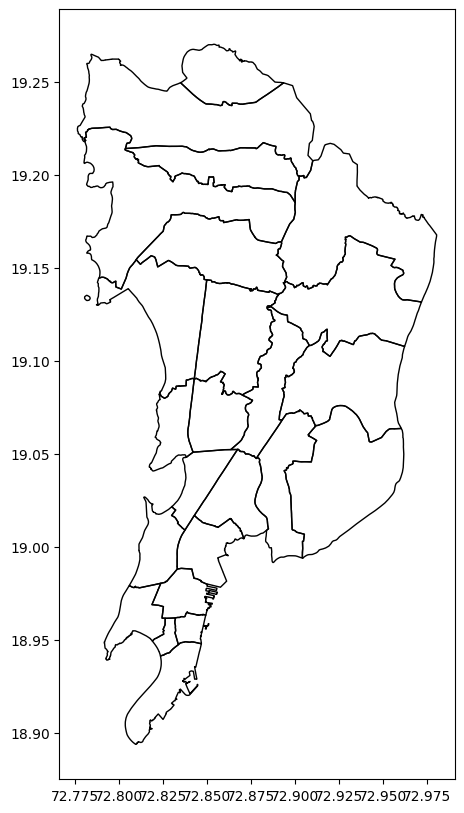

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

coords = r'C:\Users\nitaa\Downloads\foml_crime_predictor\Police_Station_Coords.csv'
boundary = r'C:\Users\nitaa\Downloads\foml_crime_predictor\mumbai-wards-map.kml'

gdf_coords = gpd.read_file(boundary, driver='KML').to_crs("EPSG:4326")
gdf_points = gpd.GeoDataFrame.from_file(coords, crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(8, 10))
gdf_coords.plot(ax=ax, color='none', edgecolor='black')
gdf_points.plot(ax=ax, color='red', markersize=20)
plt.title("Police Station Locations vs Mumbai Boundary")
plt.show()


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.ops import unary_union
from shapely import voronoi_polygons
import numpy as np
from sklearn.linear_model import LinearRegression
from flask import Flask, jsonify, request
from flask_cors import CORS
from fuzzywuzzy import process, fuzz
import datetime
import fiona  # ✅ Correct KML driver registration

print("✅ This is the UPDATED version of app.py running now!")

# --- Configuration ---
COORDS_FILE = r'C:\Users\nitaa\Downloads\foml_crime_predictor\Police_Station_Coords.csv'
HISTORY_FILE = r'C:\Users\nitaa\Downloads\foml_crime_predictor\mock_crime_history.csv'
MUMBAI_BOUNDARY_FILE = r'C:\Users\nitaa\Downloads\foml_crime_predictor\mumbai-wards-map.kml'

# Approximate bounding box used for fallback
MUMBAI_BBOX = (72.77, 18.89, 73.0, 19.28)

# --- Globals ---
app = Flask(__name__)
CORS(app)
station_models = {}
gdf_zones = None
crime_history = None
BASE_START_DATE = datetime.date(2022, 1, 1)
mumbai_boundary_polygon = None


# --- Helper ---
def clean_station_name(name):
    if not isinstance(name, str):
        return ""
    return (
        name.lower()
        .replace(" police station", "")
        .replace(" (w)", "")
        .replace(" (e)", "")
        .replace(" road", "")
        .replace(" marg", "")
        .replace("t.t.", "truck terminal")
        .replace(".", "")
        .replace(" ", "")
    )


# --- FIXED FUNCTION (Projection Safe) ---
def create_voronoi_zones(gdf_stations):
    """Creates accurate Voronoi zones clipped to Mumbai boundary (uses projected CRS)."""
    global mumbai_boundary_polygon
    print("Creating Voronoi zones (with projection correction)...")

    PROJECTED_CRS = "EPSG:32643"  # UTM zone 43N (covers Mumbai accurately)

    # --- 1️⃣ Project station data
    gdf_stations_proj = gdf_stations.to_crs(PROJECTED_CRS)

    # --- 2️⃣ Prepare boundary or fallback
    if mumbai_boundary_polygon is not None:
        boundary_proj = gpd.GeoSeries([mumbai_boundary_polygon], crs="EPSG:4326").to_crs(PROJECTED_CRS).iloc[0]
        bbox_polygon = boundary_proj.envelope
    else:
        min_lon, min_lat, max_lon, max_lat = MUMBAI_BBOX
        bbox_polygon = Polygon([
            (min_lon, min_lat), (max_lon, min_lat),
            (max_lon, max_lat), (min_lon, max_lat)
        ])
        bbox_polygon = gpd.GeoSeries([bbox_polygon], crs="EPSG:4326").to_crs(PROJECTED_CRS).iloc[0]
        boundary_proj = bbox_polygon

    # --- 3️⃣ Generate Voronoi polygons in planar CRS
    try:
        points = MultiPoint(list(gdf_stations_proj.geometry))
        polygons_collection = voronoi_polygons(points, extend_to=bbox_polygon)
    except Exception as e:
        print(f"❌ Error generating Voronoi polygons: {e}")
        return None

    gdf_voronoi_proj = gpd.GeoDataFrame(geometry=list(polygons_collection.geoms), crs=PROJECTED_CRS)

    # --- 4️⃣ Attach metadata
    gdf_stations_proj = gdf_stations_proj.reset_index(drop=True)
    gdf_voronoi_proj = gdf_voronoi_proj.reset_index(drop=True)
    if len(gdf_voronoi_proj) != len(gdf_stations_proj):
        print(f"⚠️ Warning: Voronoi polygons ({len(gdf_voronoi_proj)}) ≠ stations ({len(gdf_stations_proj)})")
        min_len = min(len(gdf_voronoi_proj), len(gdf_stations_proj))
        gdf_voronoi_proj = gdf_voronoi_proj.iloc[:min_len]
        gdf_stations_proj = gdf_stations_proj.iloc[:min_len]
    gdf_voronoi_proj["Police_Station_Coords"] = gdf_stations_proj["Police_Station_Coords"]

    # --- 5️⃣ Clip to Mumbai boundary
    print("Clipping Voronoi polygons to Mumbai boundary...")
    gdf_voronoi_proj["geometry"] = gdf_voronoi_proj.geometry.intersection(boundary_proj)
    gdf_voronoi_proj["geometry"] = gdf_voronoi_proj.buffer(0)  # Fix invalid geometries

    # --- 6️⃣ Clean up
    gdf_voronoi_proj = gdf_voronoi_proj[~gdf_voronoi_proj.is_empty]
    gdf_voronoi_proj = gdf_voronoi_proj[gdf_voronoi_proj.geometry.area > 1e4]

    # --- 7️⃣ Reproject back to lat/lon
    gdf_voronoi = gdf_voronoi_proj.to_crs("EPSG:4326")

    print(f"✅ Accurate Voronoi zones created and clipped: {len(gdf_voronoi)} zones.")
    return gdf_voronoi


# --- ML TRAINING ---
def train_all_models(df_history, all_stations):
    print(f"Training {len(all_stations)} ML models...")
    models = {}
    historical_stations = df_history['Police_Station_History'].unique()
    for station_coords_name in all_stations:
        clean_coords_name = clean_station_name(station_coords_name)
        best_match, score = process.extractOne(clean_coords_name, historical_stations, scorer=fuzz.token_sort_ratio)
        if score > 80:
            station_df = df_history[df_history['Police_Station_History'] == best_match].copy()
            station_df['Date'] = pd.to_datetime(station_df['Date'])
            station_df = station_df.sort_values(by='Date')
            if len(station_df) > 1:
                station_df['time_index'] = (
                    (station_df['Date'].dt.year - BASE_START_DATE.year) * 12 +
                    (station_df['Date'].dt.month - BASE_START_DATE.month)
                )
                X = station_df[['time_index']]
                y = station_df['Total_Crimes']
                model = LinearRegression()
                model.fit(X, y)
                models[station_coords_name] = {'model': model, 'history_name': best_match}
    print(f"Training complete. {len(models)} models trained.")
    return models


# --- PREDICTION ---
def predict_crime(station_name, target_date_str):
    global crime_history, station_models, BASE_START_DATE
    target_date = datetime.datetime.strptime(target_date_str, '%Y-%m-%d').date()
    if station_name not in station_models:
        return 0, 'N/A'
    model_data = station_models[station_name]
    history_name = model_data['history_name']
    historical_record = crime_history[
        (crime_history['Police_Station_History'] == history_name) &
        (crime_history['Date_str'] == target_date_str)
    ]
    if not historical_record.empty:
        return int(historical_record['Total_Crimes'].values[0]), 'Historical'
    model = model_data['model']
    time_index = ((target_date.year - BASE_START_DATE.year) * 12 +
                  (target_date.month - BASE_START_DATE.month))
    prediction = model.predict(np.array([[time_index]]))
    return int(max(0, prediction[0])), 'Predicted'


# --- COLOR CODING ---
def get_color(crime, low_thresh, mid_thresh):
    if crime <= 0:
        return '#9CA3AF'
    elif crime <= low_thresh:
        return '#22C55E'
    elif crime <= mid_thresh:
        return '#FACC15'
    else:
        return '#F97316'


# --- DATA LOADING ---
@app.before_request
def load_data_and_models():
    global gdf_zones, station_models, crime_history, mumbai_boundary_polygon
    if gdf_zones is not None:
        return
    print("Loading data for the first time...")

    # ✅ Load Mumbai KML boundary
    try:
        print(f"Loading KML boundary file from: {MUMBAI_BOUNDARY_FILE}")
        fiona.supported_drivers['KML'] = 'rw'
        gdf_mumbai = gpd.read_file(MUMBAI_BOUNDARY_FILE, driver='KML')
        gdf_mumbai = gdf_mumbai.to_crs("EPSG:4326")
        mumbai_boundary_polygon = unary_union(gdf_mumbai.geometry)
        print(f"✅ Mumbai KML boundary loaded successfully with {len(gdf_mumbai)} features.")
    except Exception as e:
        print(f"⚠️ Could not load KML boundary: {e}")
        print("⚠️ Proceeding without boundary clipping (rectangle fallback).")

    # Load Crime History
    df_history = pd.read_csv(HISTORY_FILE, encoding='utf-8-sig')
    df_history['Date_str'] = pd.to_datetime(df_history['Date']).dt.strftime('%Y-%m-%d')
    df_history['Police_Station_History'] = df_history['Police_Station'].apply(clean_station_name)
    crime_history = df_history

    # Load Police Station Coordinates
    df_coords = pd.read_csv(COORDS_FILE, encoding='utf-8-sig').dropna(subset=['Latitude', 'Longitude'])
    df_coords = df_coords.rename(columns={df_coords.columns[0]: 'Police_Station'})
    gdf_stations = gpd.GeoDataFrame(df_coords,
        geometry=gpd.points_from_xy(df_coords.Longitude, df_coords.Latitude),
        crs="EPSG:4326")
    gdf_stations['Police_Station_Coords'] = gdf_stations['Police_Station']

    # Create Voronoi Zones (accurate projected version)
    gdf_zones = create_voronoi_zones(gdf_stations)
    if gdf_zones is None:
        raise RuntimeError("Failed to create Voronoi zones.")

    # Train ML Models
    station_models = train_all_models(df_history, gdf_stations['Police_Station_Coords'].unique())

    # Merge Model Info
    gdf_zones = gdf_zones.merge(
        pd.DataFrame([
            {'Police_Station_Coords': k, 'history_name': v['history_name']}
            for k, v in station_models.items()
        ]),
        on='Police_Station_Coords', how='left'
    )
    print("--- Backend is ready ---")


# --- API ROUTE ---
@app.route('/get_crime_map')
def get_crime_map():
    selected_month = request.args.get('month')
    if not selected_month:
        return jsonify({"error": "Missing 'month' parameter"}), 400
    results = []
    if gdf_zones is None or gdf_zones.empty:
        return jsonify({"error": "Voronoi zones not loaded"}), 500
    for _, row in gdf_zones.iterrows():
        station_name_coords = row['Police_Station_Coords']
        crime, data_type = predict_crime(station_name_coords, selected_month)
        results.append({
            'Police_Station_Coords': station_name_coords,
            'history_name': row.get('history_name', 'N/A'),
            'crime': crime,
            'data_type': data_type
        })
    df_results = pd.DataFrame(results)
    crime_values = df_results[df_results['crime'] > 0]['crime']
    low_thresh, mid_thresh = (
        (crime_values.quantile(0.33), crime_values.quantile(0.66))
        if not crime_values.empty else (0, 0)
    )
    df_results['color_zone'] = df_results['crime'].apply(get_color, args=(low_thresh, mid_thresh))
    gdf_map_data = gdf_zones.merge(df_results, on='Police_Station_Coords')
    print(f"Returning {len(gdf_map_data)} map zones for {selected_month}.")
    return gdf_map_data.to_json()


# --- ENTRY POINT ---
if __name__ == '__main__':
    load_data_and_models()
    app.run(debug=True, port=5000)
